In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
from astropy.visualization import hist
import simpy
from scipy.stats import norm

In [2]:
''' Simple FIFO scheduling in a Movie Theatre'''

wait_times = []

class Theater(object):
    def __init__(self, env, num_cashiers, mu):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(random.expovariate(mu))      #mu capacity of each cashier
        
def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    '''
    arrival_time = env.now
    
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
    
    # Moviegoer heads into the theater
    wait_times.append(env.now - arrival_time)   
    '''

    # Timestamp when person arrived in queue
    tkt_request_ts = env.now
    print("Customer {} entering queue at {:.4f} minute".format(moviegoer, tkt_request_ts))
    
    # Request to get serviced
    tkt_request = theater.cashier.request()
    # Yield this process until server is available 
    yield tkt_request

    # Reached the cashier
    # Let's see if we had to wait to get to cashier.
    if env.now > tkt_request_ts:
        print("Customer {} waited {:.4f} minutes for reaching the server".format(moviegoer, env.now - tkt_request_ts))
        wait_times.append(env.now - tkt_request_ts) 
    else:
        print("Customer {} didnot wait!!".format(moviegoer))
        wait_times.append(0)

    # Yield this process again. Now wait until our length of service.
    # This is the actual service period
    yield env.process(theater.purchase_ticket(moviegoer))

    # All done !! Leaving the queue. 
    theater.cashier.release(tkt_request)
    print("Customer {} leaving queue at {:.4f} minute.".format(moviegoer,env.now))
     
    
def cust_generator(env, num_cashiers, mu, lamb, stoptime):
    theater = Theater(env, num_cashiers, mu)
    moviegoer = 0
   
    while env.now < stoptime:
        
        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))
        
        yield env.timeout(random.expovariate(lamb))  # Wait a bit before generating a new person, lamb =  mean arrival rate

        
def avg_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    var = statistics.variance(wait_times)
    return average_wait, var

def get_user_input():
    num_cashiers = input("Input # of cashiers working: ")
    lamb = input("Input mean arrival rate, lambda (in persons per min): ")
    mu = input("Input mean capacity, mu , of each cashier (in persons per min): ")
    stoptime = input("Input time after which no new arrivals are allowed (in min): ")
    params = [num_cashiers, mu, lamb, stoptime]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Invalid input. The simulation will use default values:",
            "\n1 cashier, 3 lambda, 4 mu, No stop time.\n",
        )
        params = [1, 4, 3,simpy.core.Infinity]
    return params

random.seed(42)
num_cashiers, mu, lamb, stop = get_user_input()


# Run the simulation
env = simpy.Environment()
env.process(cust_generator(env, num_cashiers, mu, lamb, stop))
env.run(until=10)

# View the results
t , var = avg_wait_time(wait_times)
print("Simulation Stopped...",f"\nThe average wait time is {t} minutes with a variance of {var}.")

Input # of cashiers working: 2
Input mean arrival rate, lambda (in persons per min): 5
Input mean capacity, mu , of each cashier (in persons per min): 6
Input time after which no new arrivals are allowed (in min): 8
Customer 1 entering queue at 0.0000 minute
Customer 1 didnot wait!!
Customer 1 leaving queue at 0.0042 minute.
Customer 2 entering queue at 0.2040 minute
Customer 2 didnot wait!!
Customer 2 leaving queue at 0.2461 minute.
Customer 3 entering queue at 0.2683 minute
Customer 3 didnot wait!!
Customer 3 leaving queue at 0.4565 minute.
Customer 4 entering queue at 0.5351 minute
Customer 4 didnot wait!!
Customer 4 leaving queue at 0.5502 minute.
Customer 5 entering queue at 0.9805 minute
Customer 5 didnot wait!!
Customer 5 leaving queue at 0.9856 minute.
Customer 6 entering queue at 1.0901 minute
Customer 6 didnot wait!!
Customer 7 entering queue at 1.1395 minute
Customer 7 didnot wait!!
Customer 8 entering queue at 1.1448 minute
Customer 7 leaving queue at 1.1764 minute.
Custome

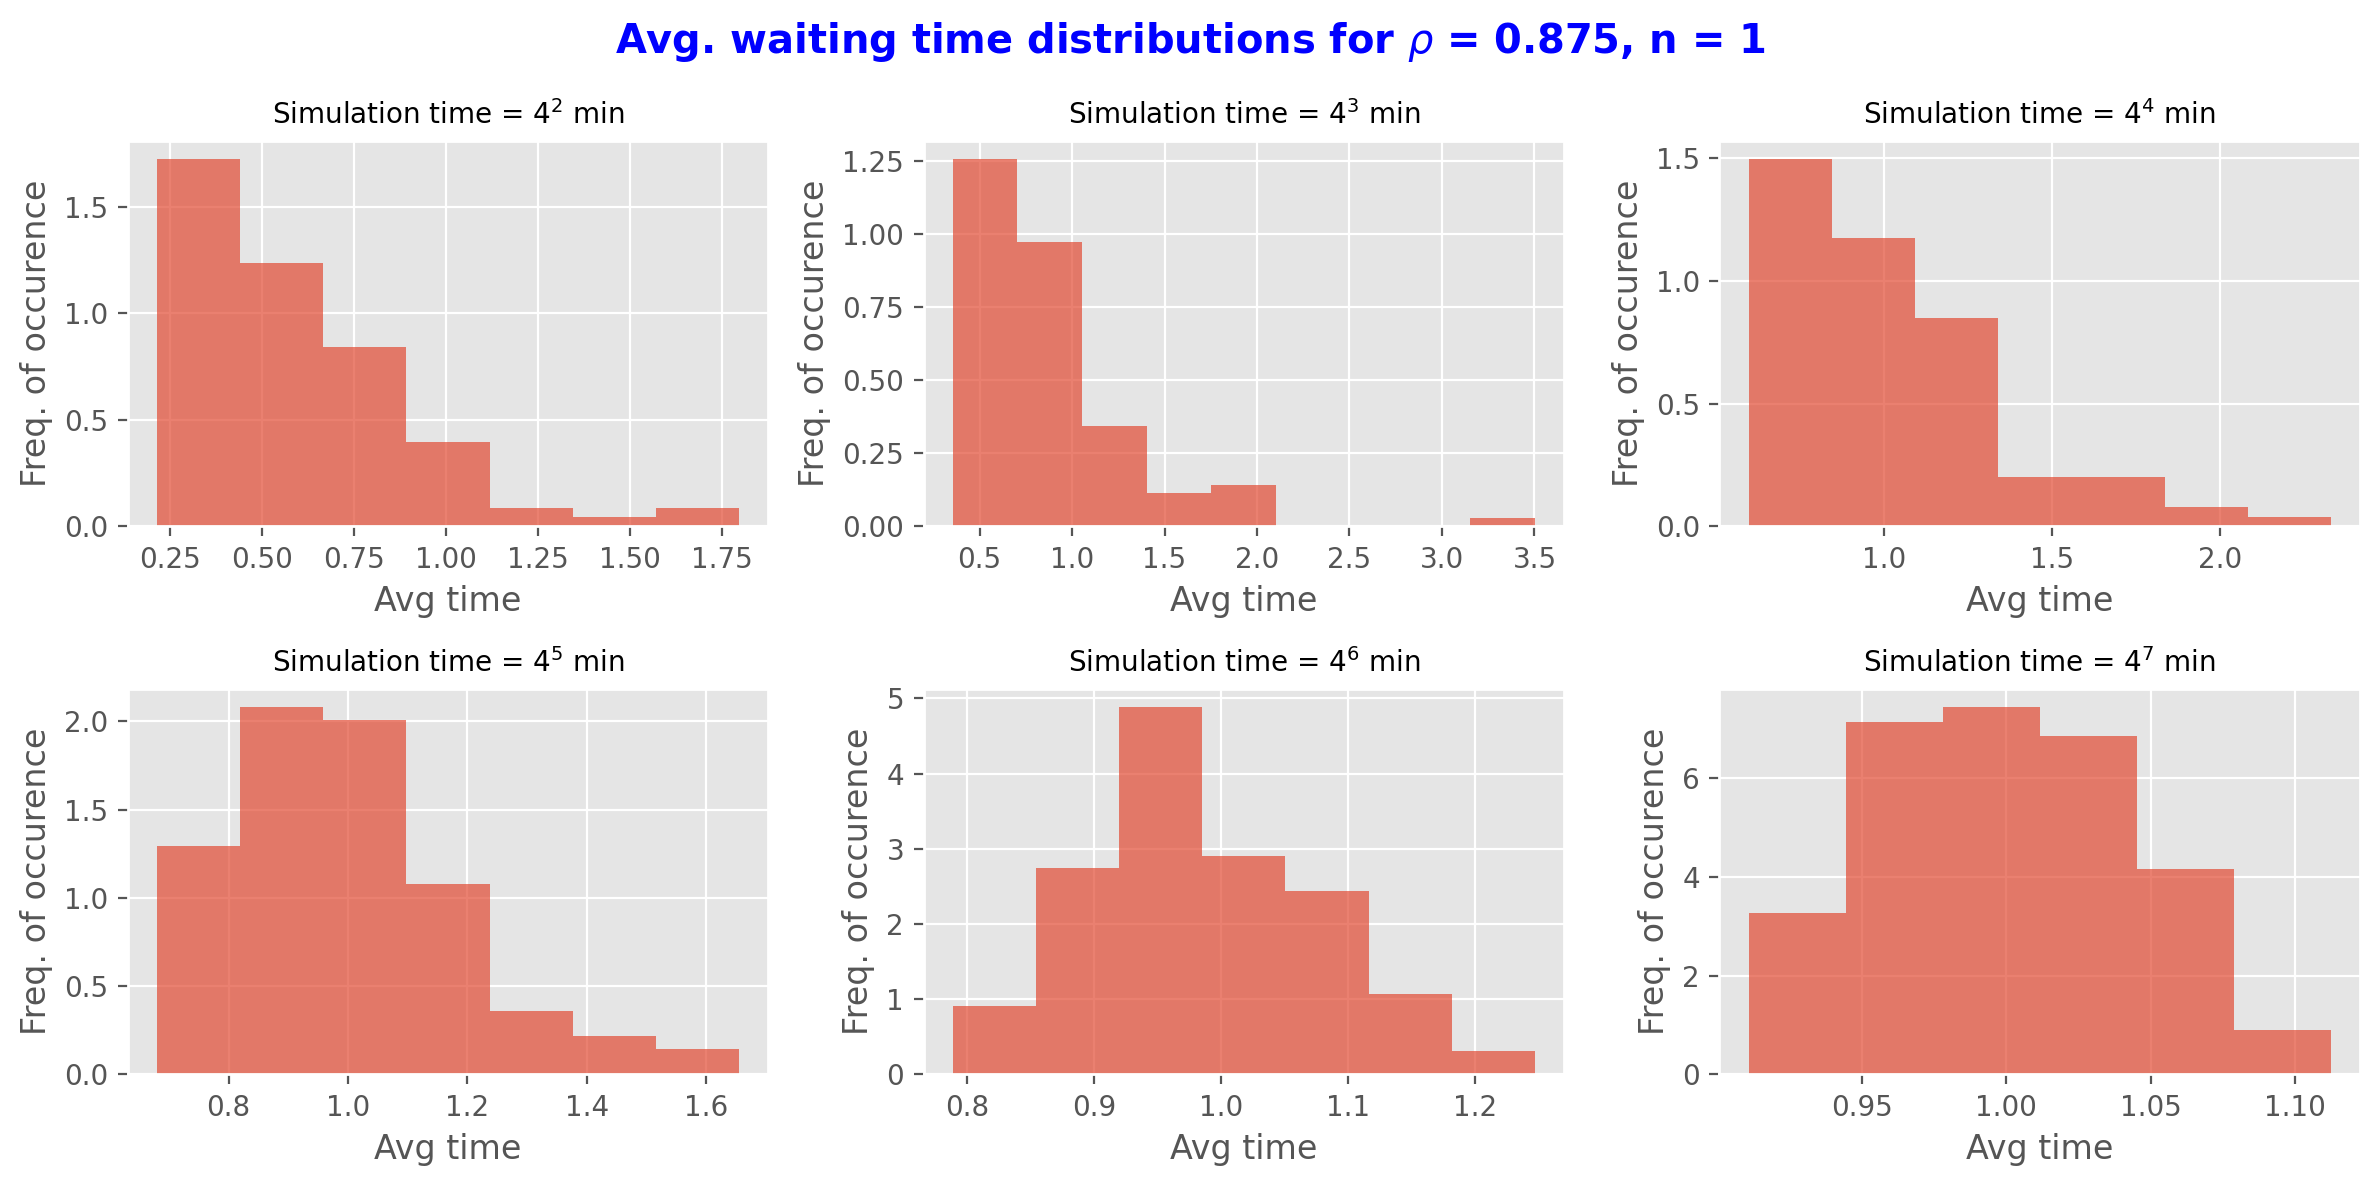

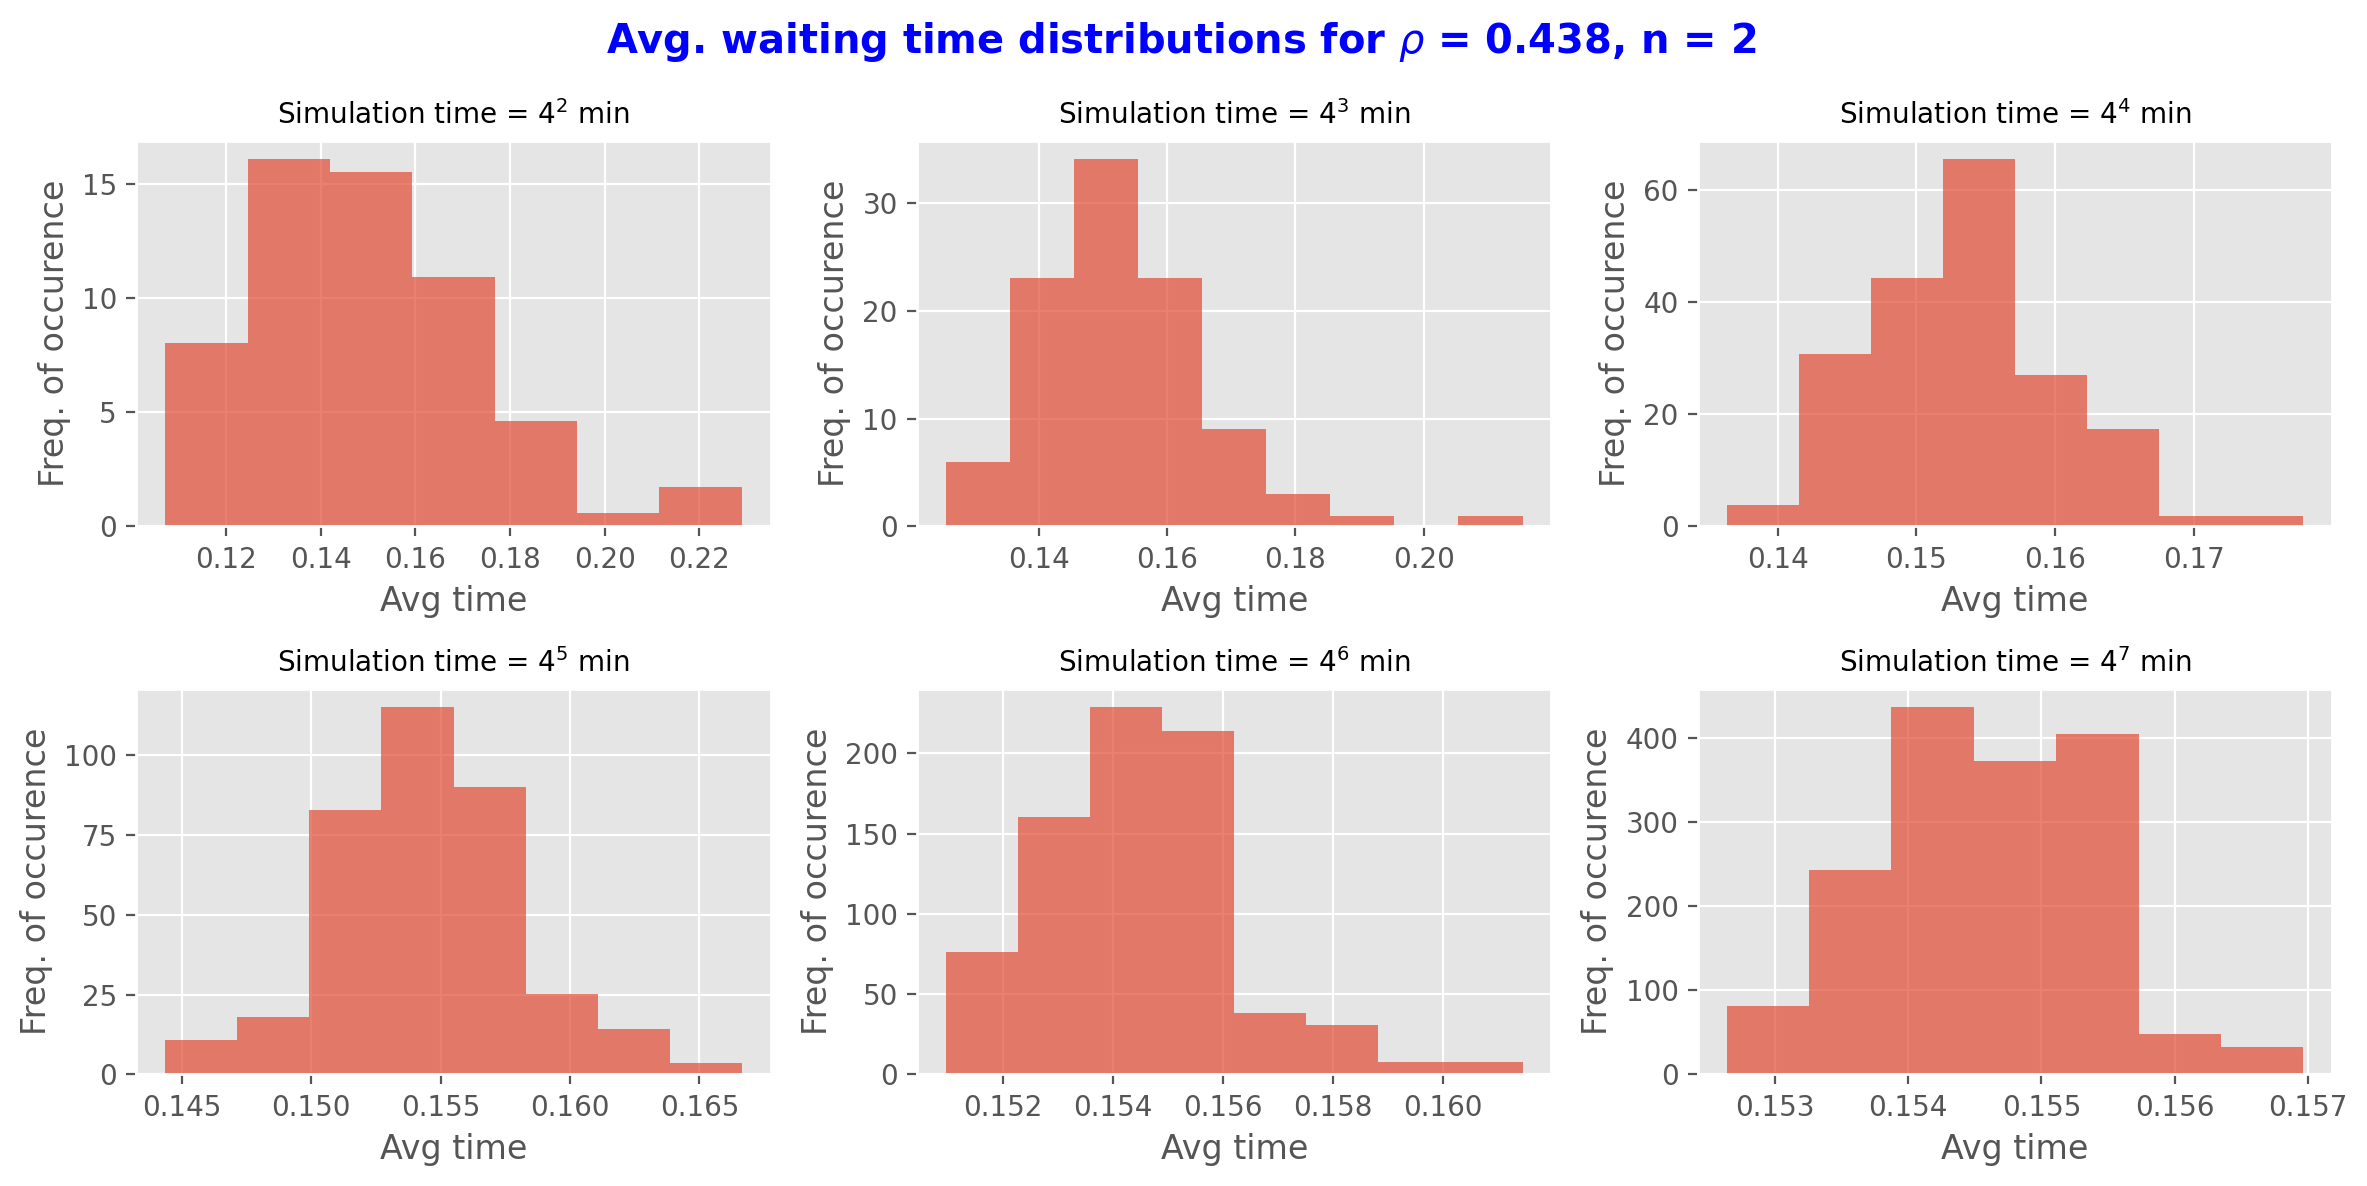

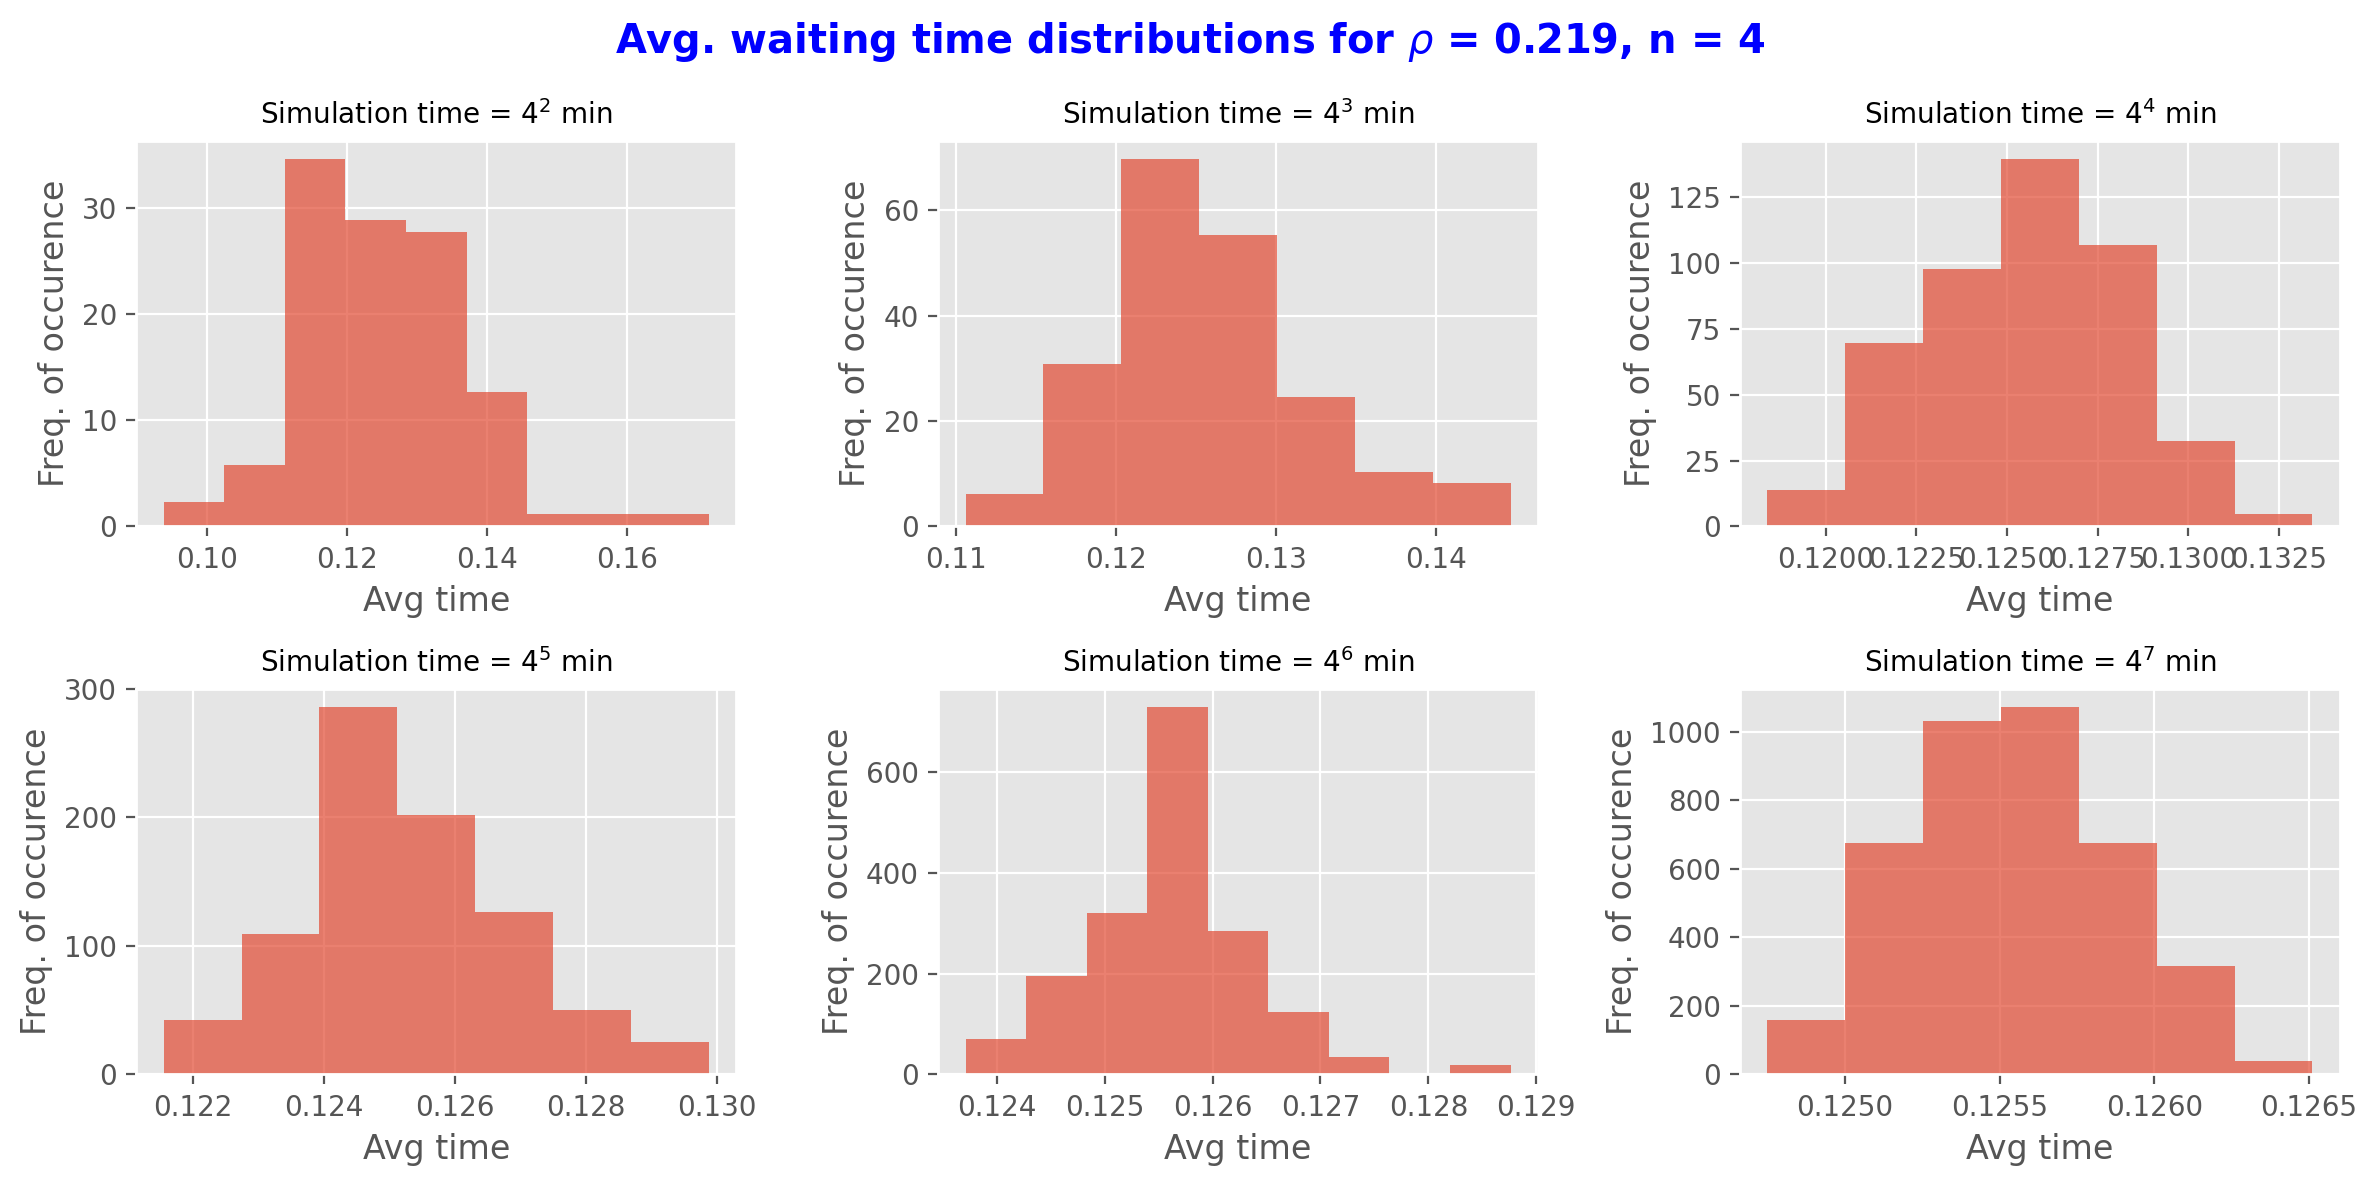

In [3]:
'''Test to find the optimum simulation times for different pho values. Computationally expensive. '''

simtime = np.fromiter((4**(x+1) for x in range(1,7)), int)
lamb = 7; mu = 8
num_cashiers = np.fromiter((2**x for x in range(3)) ,int)   #(1,2,4)
wait_times = []

def flow(env, moviegoer, theater):

    # Timestamp when person arrived in queue
    arrival_time = env.now
   
    # Request to get serviced
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
    
    wait_times.append(env.now - arrival_time) 

def cust_gen(env, num_cashiers, mu, lamb):
    
    theater = Theater(env, num_cashiers, mu)
    moviegoer = 0
   
    while True:
        # Wait a bit before generating a new person, lamb =  mean arrival rate
        yield env.timeout(random.expovariate(lamb))
        moviegoer += 1
        env.process(flow(env, moviegoer, theater))


#random.seed(4249)

#We check the optimal simtime at different system loads (pho) for minimizing the intialization bias of our simulations 

wait_diffrho = [[]*x for x in range(18)]

for l,k in enumerate(num_cashiers):

    for i,j in enumerate(simtime):
       
        for m in range(100):
            env = simpy.Environment()
            env.process(cust_gen(env, k, mu, lamb))
            env.run(until=j)
            t , var = avg_wait_time(wait_times)
            wait_diffrho[(6*l)+i].append(t)
            wait_times = []    
            
#Plotting for different rho values

for i,j in enumerate (num_cashiers):
    plt.style.use('ggplot')
    m = "medium"; l = "x-large"
    fig = plt.figure(figsize=(12,6), dpi = 200)
    plt.suptitle(r"Avg. waiting time distributions for $\rho$ = {:.3f}, n = {}".format(lamb/(j*mu), j), color='blue',fontsize=l,fontweight='bold')
    plt.subplot(2,3,1)
    hist(wait_diffrho[6*i], bins= "scott", density=True, alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^2$ min",fontsize=m)
    plt.subplot(2,3,2)
    hist(wait_diffrho[(6*i)+1], bins= "scott", density=True,alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^3$ min",fontsize=m)
    plt.subplot(2,3,3)
    hist(wait_diffrho[(6*i)+2], bins= "scott", density=True,alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^4$ min",fontsize=m)
    plt.subplot(2,3,4)
    hist(wait_diffrho[(6*i)+3], bins= "scott", density=True,alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^5$ min",fontsize=m)
    plt.subplot(2,3,5)
    hist(wait_diffrho[(6*i)+4], bins= "scott", density=True,alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^6$ min",fontsize=m)
    plt.subplot(2,3,6)
    hist(wait_diffrho[(6*i)+5], bins= "scott", density=True,alpha=0.7)
    plt.xlabel('Avg time')
    plt.ylabel('Freq. of occurence')
    plt.title("Simulation time = $4^7$ min",fontsize=m)
    plt.tight_layout()
    plt.show()

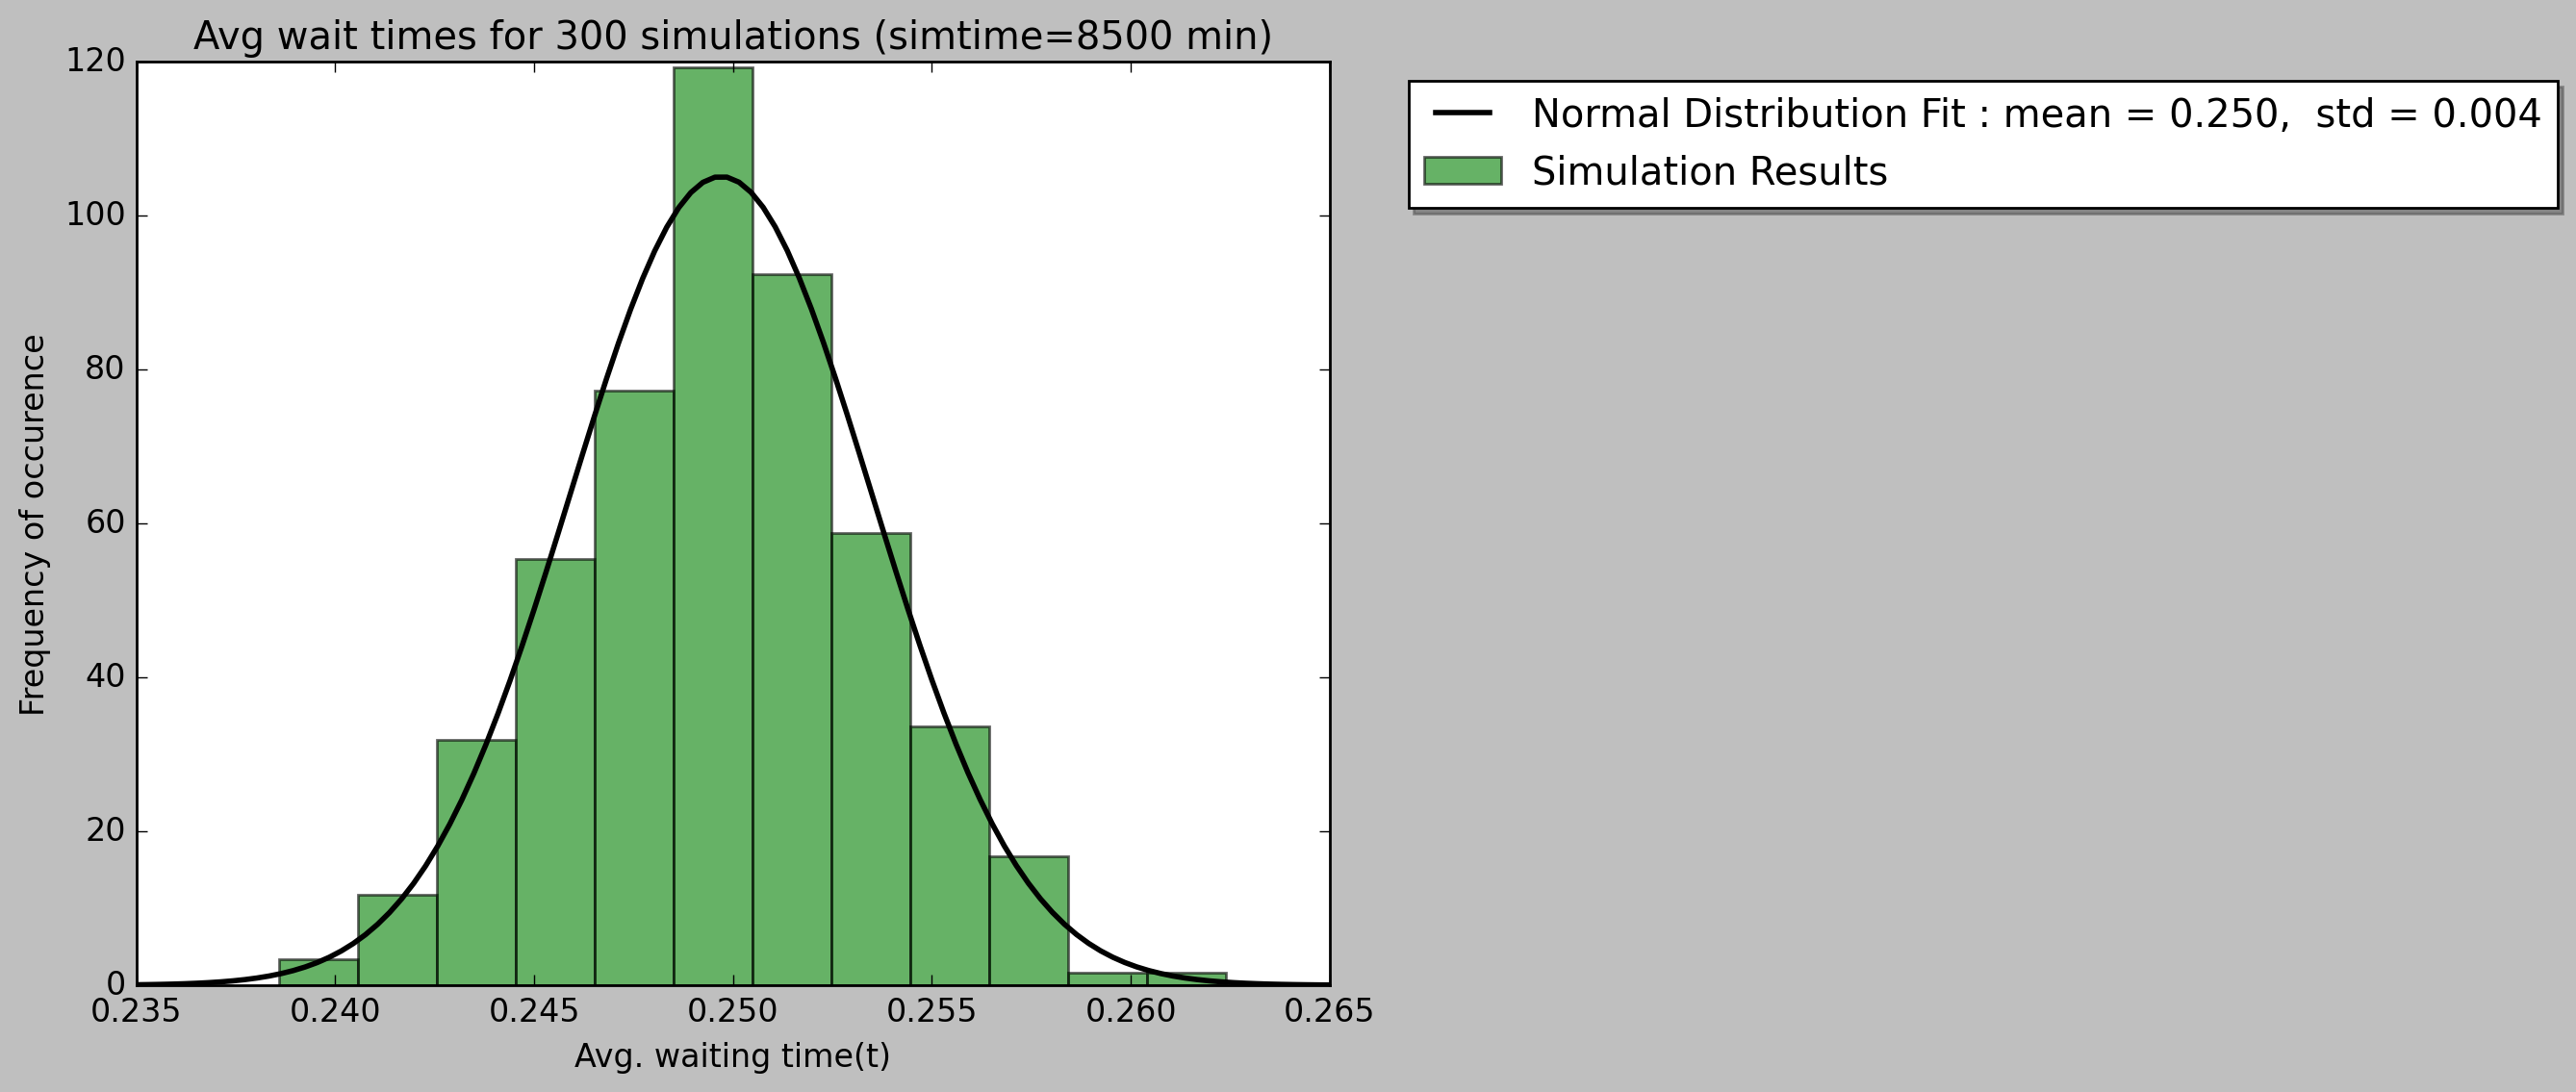

In [5]:
''' Avg waiting times for optimized simulation times . Params (n=1, lambda=4, mu=5)'''

avgwait_list = []
wait_times = []

for i in range(300):
    env = simpy.Environment()
    env.process(cust_gen(env, 1, 5, 4))
    env.run(until=8500)
    t , var = avg_wait_time(wait_times)
    avgwait_list.append(t)
    wait_times = []
    
plt.style.use('classic')
fig = plt.figure(dpi=200)
mean, std = norm.fit(avgwait_list)
# Plot the histogram.
hist(avgwait_list, bins= "scott", density=True,color='green',alpha=0.6,label="Simulation Results")
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution Fit : mean = %.3f,  std = %.3f" % (mean, std))
plt.xlabel('Avg. waiting time(t)')
plt.ylabel('Frequency of occurence')
plt.title("Avg wait times for 300 simulations (simtime=8500 min)")
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1),shadow=True)
plt.show()

Input # of servers: 2
Input mean arrival rate, lambda (in persons per min): 5
Input mean capacity, mu , of each server (in persons per min): 6
Simulation stopped... 
The average wait time is 0.021092091102669647 minutes with a variance of 0.0024966299917941414.


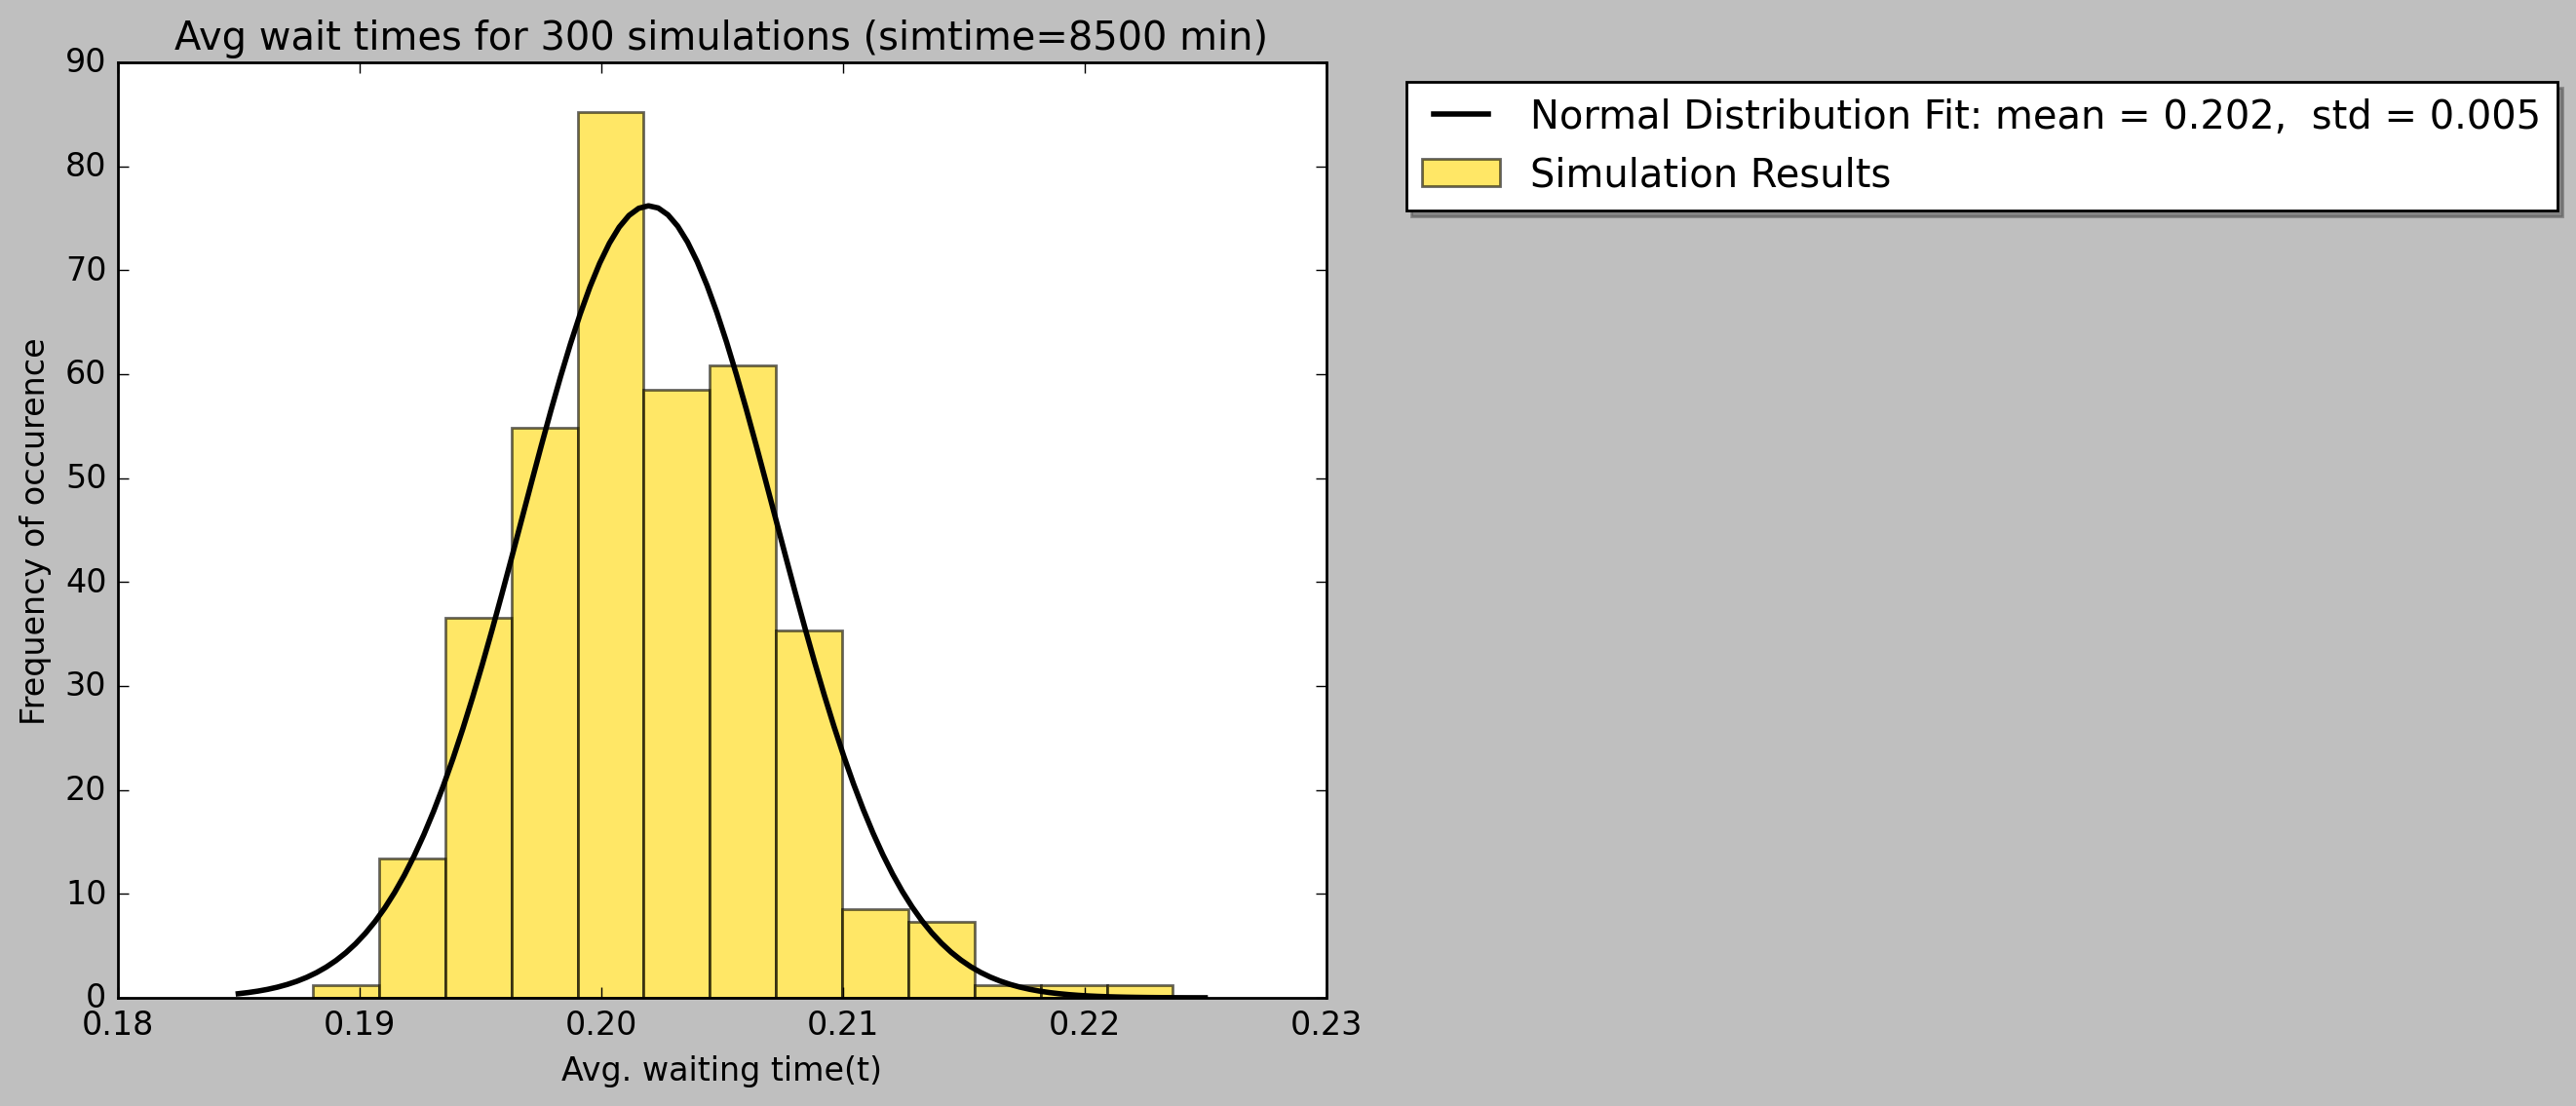

In [7]:
'''Shortest Job First Scheduling and comparison plot'''

wait_times = []
service_times = []
cust_leave_list=[]

class Qu(object):
    def __init__(self, env, num_server, mu):
        self.env = env
        self.server = simpy.PriorityResource(env, num_server) 
        self.priority = 1
        self.servtime = 1
        
    def service(self, cust):
        yield self.env.timeout(self.servtime)      #mu capacity of each server
        
    def deter_priority(self, cust):
        self.servtime = random.expovariate(mu)
        self.priority = int(1000000 - 1/(self.servtime)**2)   # chosen function returns lower integer values for shorter service times. Completely random could have been anything else
        
        
def flow(env, cust, qu):
    # Customer arrives in the queue
    
    arrival_time = env.now
    reach_server = 0
    #determine the priority
    qu.deter_priority(cust)
    with qu.server.request(priority = qu.priority) as request:
        yield request
        # Customer heads to the server
        reach_server= env.now
        wait_times.append(reach_server - arrival_time) 
        yield env.process(qu.service(cust))
        
    #Customer leaves the queue
    service_times.append(env.now - reach_server)  
    cust_leave_list.append(cust)
        
    
    '''
    # Timestamp when person arrived in queue
    tkt_request_ts = env.now
    print("Customer {} entering queue at {:.4f} minute".format(cust, tkt_request_ts))
    
    qu.deter_priority(cust)
    # Request to get serviced
    tkt_request = qu.server.request(priority = qu.priority )
    # Yield this process until server is available 
    yield tkt_request

    # Reached the server
    # Let's see if we had to wait to get to server.
    if env.now > tkt_request_ts:
        print("Customer {} waited {:.4f} minutes for reaching the server".format(cust, env.now - tkt_request_ts))
        wait_times.append(env.now - tkt_request_ts) 
    else:
        print("Customer {} didnot wait!!".format(cust))
        wait_times.append(0)

    # Yield this process again. Now wait until our length of service.
    # This is the actual service period
    yield env.process(qu.service(cust))

    # All done !! Leaving the queue. 
    qu.server.release(tkt_request)
    print("Customer {} leaving queue at {:.4f} minute.".format(cust,env.now))''' 
    
def cust_generator(env, num_server, mu, lamb):
    qu = Qu(env, num_server, mu)
    cust = 0
   
    while True:
        
        cust += 1
        env.process(flow(env, cust, qu))
        
        yield env.timeout(random.expovariate(lamb))  # Wait a bit before generating a new person, lamb =  mean arrival rate

        
def avg_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    var = statistics.variance(wait_times)
    return average_wait, var

def get_user_input():
    num_server = input("Input # of servers: ")
    lamb = input("Input mean arrival rate, lambda (in persons per min): ")
    mu = input("Input mean capacity, mu , of each server (in persons per min): ")
    params = [num_server, mu, lamb]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Invalid input. The simulation will use default values:",
            "\n1 server, 3 lambda, 4 mu, No stop time.\n",
        )
        params = [1, 4, 3]
    return params

num_server, mu, lamb = get_user_input()


# Run the simulation
env = simpy.Environment()
env.process(cust_generator(env, num_server, mu, lamb))
env.run(until=10)

# View the results
t , var = avg_wait_time(wait_times)
print("Simulation stopped...",f"\nThe average wait time is {t} minutes with a variance of {var}.")
#print(service_times,"\n", cust_leave_list)


avgwait_list = []
for i in range(300):
    env = simpy.Environment()
    env.process(cust_generator(env, 1, 5, 4))            #params
    env.run(until=8500)
    t , var = avg_wait_time(wait_times)
    avgwait_list.append(t)
    wait_times = []
    
plt.style.use('classic')
fig = plt.figure(dpi=200)
mean, std = norm.fit(avgwait_list)
# Plot the histogram.
hist(avgwait_list, bins= "scott", density=True,alpha=0.6,color='gold',label="Simulation Results")
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label="Normal Distribution Fit: mean = %.3f,  std = %.3f" % (mean, std))
plt.xlabel('Avg. waiting time(t)')
plt.ylabel('Frequency of occurence')
plt.title("Avg wait times for 300 simulations (simtime=8500 min)")
plt.legend(loc='upper left',bbox_to_anchor=(1.05, 1),shadow=True)
plt.show()

In [8]:
'''M/D/1 and M/D/n queues - should add some plots here!!'''


wait_times = []
D = 1         # fixed service time of 1 min


class Theater(object):
    def __init__(self, env, num_cashiers, mu):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)

    def purchase_ticket(self, moviegoer):
        yield self.env.timeout(D)      #mu capacity of each cashier
        
def go_to_movies(env, moviegoer, theater):
    # Moviegoer arrives at the theater
    '''
    arrival_time = env.now
    
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
    
    # Moviegoer heads into the theater
    wait_times.append(env.now - arrival_time)   
    '''

    # Timestamp when person arrived in queue
    tkt_request_ts = env.now
    print("Customer {} entering queue at {:.4f} minute".format(moviegoer, tkt_request_ts))
    
    # Request to get serviced
    tkt_request = theater.cashier.request()
    # Yield this process until server is available 
    yield tkt_request

    # Reached the server
    # Let's see if we had to wait to get to server.
    if env.now > tkt_request_ts:
        print("Customer {} waited {:.4f} minutes for reaching the server".format(moviegoer, env.now - tkt_request_ts))
        wait_times.append(env.now - tkt_request_ts) 
    else:
        print("Customer {} didnot wait!!".format(moviegoer))
        wait_times.append(0)

    # Yield this process again. Now wait until our length of service.
    # This is the actual service period
    yield env.process(theater.purchase_ticket(moviegoer))

    # All done !! Leaving the queue. 
    theater.cashier.release(tkt_request)
    print("Customer {} leaving queue at {:.4f} minute.".format(moviegoer,env.now))
  
        
    
def cust_generator(env, num_cashiers, mu, lamb, stoptime):
    theater = Theater(env, num_cashiers, mu)
    moviegoer = 0
   
    while env.now < stoptime:
        
        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))
        
        yield env.timeout(random.expovariate(lamb))  # Wait a bit before generating a new person, lamb =  mean arrival rate

        
def avg_wait_time(wait_times):
    average_wait = statistics.mean(wait_times)
    var = statistics.variance(wait_times)
    return average_wait, var

def get_user_input():
    num_cashiers = input("Input # of cashiers working: ")
    lamb = input("Input mean arrival rate, lambda (in persons per min): ")
    mu = input("Input mean capacity, mu , of each cashier (in persons per min): ")
    stoptime = input("Input time after which no new arrivals are allowed (in min): ")
    params = [num_cashiers, mu, lamb, stoptime]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Invalid input. The simulation will use default values:",
            "\n1 cashier, 3 lambda, 4 mu, No stop time.\n",
        )
        params = [1, 4, 3,simpy.core.Infinity]
    return params

random.seed(42)
num_cashiers, mu, lamb, stop = get_user_input()

# Run the simulation
env = simpy.Environment()
env.process(cust_generator(env, num_cashiers, mu, lamb, stop))
env.run(until=10)

# View the results
t , var = avg_wait_time(wait_times)
print("Simulation stopped...",f"\nThe average wait time is {t} minutes with a variance of {var}.")

Input # of cashiers working: 2
Input mean arrival rate, lambda (in persons per min): 5
Input mean capacity, mu , of each cashier (in persons per min): 6
Input time after which no new arrivals are allowed (in min): 8
Customer 1 entering queue at 0.0000 minute
Customer 1 didnot wait!!
Customer 2 entering queue at 0.2040 minute
Customer 2 didnot wait!!
Customer 3 entering queue at 0.2091 minute
Customer 4 entering queue at 0.2734 minute
Customer 5 entering queue at 0.3239 minute
Customer 6 entering queue at 0.5906 minute
Customer 7 entering queue at 0.8165 minute
Customer 1 leaving queue at 1.0000 minute.
Customer 3 waited 0.7909 minutes for reaching the server
Customer 2 leaving queue at 1.2040 minute.
Customer 4 waited 0.9306 minutes for reaching the server
Customer 8 entering queue at 1.2619 minute
Customer 9 entering queue at 1.2801 minute
Customer 10 entering queue at 1.3897 minute
Customer 11 entering queue at 1.3958 minute
Customer 12 entering queue at 1.4451 minute
Customer 13 ent

[4.2636483228679385, 3.640290101258493, 5.4517456879227595, 5.939695329680171, 6.084181635998708, 9.030731710866686, 6.228313972726433, 2.6548138214736845, 3.990016949967557, 3.154608716366959]
[5.410107512352084, 5.558457860327463, 4.631155641484721, 4.1638166535762275, 5.028924729922764, 5.633030919149654, 5.633934854475624, 5.358104414741128, 4.965272252625976, 4.257958527451561]


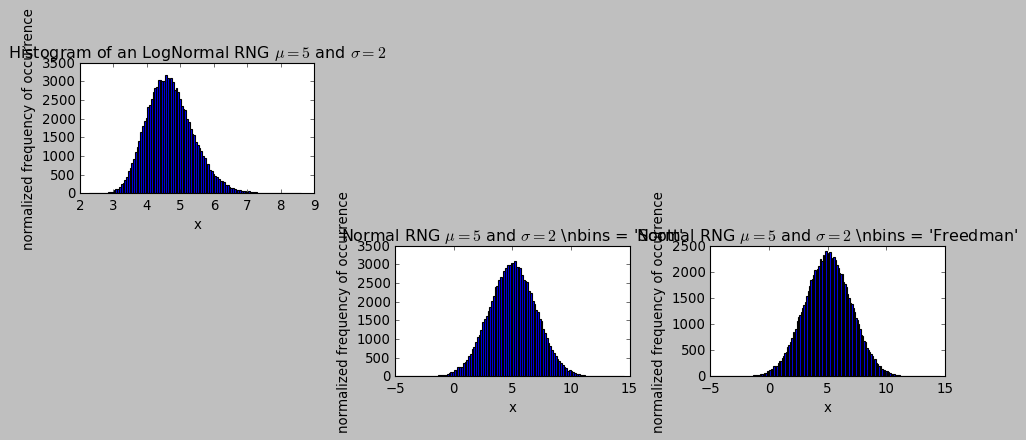

In [9]:
'''Testing to find some longtail distributions one possibility is the lognormal distribution'''

mu = 5 
var =4


#random.lognormvariate(np.log(mu**2/np.sqrt(mu**2+var)), np.log((mu**2 + var)/mu**2))


normSamples = [random.normalvariate(5.0, 2.0) for i in range(100000)]
print(normSamples[0:10])  #Take a look at the first 10

fig = plt.figure(figsize=(12,5))

plt.subplot(2,3,6)
hist(normSamples, bins='freedman')
#axis.hist(normSamples, bins=100)
plt.title(r"Normal RNG $\mu = 5$ and $\sigma = 2$ \nbins = 'Freedman'")
plt.xlabel("x")
plt.ylabel("normalized frequency of occurrence")

plt.subplot(235)
hist(normSamples,bins='scott')
#axis.hist(normSamples, bins=100)
plt.title(r"Normal RNG $\mu = 5$ and $\sigma = 2$ \nbins = 'Scott'")
plt.xlabel("x")
plt.ylabel("normalized frequency of occurrence")

logSamples = [random.lognormvariate(np.log(mu**2/np.sqrt(mu**2+var)), np.log((mu**2 + var)/mu**2)) for i in range(100000)]
print(logSamples[0:10])  #Take a look at the first 10
plt.subplot(231)
hist(logSamples,bins='scott')
#axis.hist(logSamples, bins=100)
plt.title(r"Histogram of an LogNormal RNG $\mu = 5$ and $\sigma = 2$")
plt.xlabel("x")
plt.ylabel("normalized frequency of occurrence")
plt.tight_layout()
plt.show()